In [1]:
from torchvision import datasets
import torch
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

device = 'cpu'
data_folder = ''
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

tr_images = fmnist.data
tr_targets = fmnist.targets
val_fmnist = datasets.FashionMNIST(data_folder,
                                   download=True,
                                   train=False)

val_images = val_fmnist.data
val_targets = val_fmnist.targets

100%|███████████████████████████████████████| 26.4M/26.4M [01:40<00:00, 263kB/s]


Extracting FashionMNIST/raw/train-images-idx3-ubyte.gz to FashionMNIST/raw



100%|███████████████████████████████████████| 29.5k/29.5k [00:00<00:00, 127kB/s]


Extracting FashionMNIST/raw/train-labels-idx1-ubyte.gz to FashionMNIST/raw



100%|███████████████████████████████████████| 4.42M/4.42M [00:04<00:00, 923kB/s]


Extracting FashionMNIST/raw/t10k-images-idx3-ubyte.gz to FashionMNIST/raw



100%|██████████████████████████████████████| 5.15k/5.15k [00:00<00:00, 3.94MB/s]

Extracting FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to FashionMNIST/raw



In [15]:
import albumentations as A
from albumentations.augmentations.geometric.transforms import ShiftScaleRotate

# Definindo a transformação
aug = A.Compose([
    ShiftScaleRotate(shift_limit_x=0.1, shift_limit_y=0, scale_limit=0, rotate_limit=0, p=1, border_mode=0),
])

In [17]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y, aug=None):
        self.x, self.y = x, y
        self.aug = aug

    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        x = np.array(x)  # Convertendo para numpy para aplicar a transformação
        if self.aug:
            # Aplicando a transformação
            x = self.aug(image=x)["image"]
        x = torch.tensor(x).float()  # Convertendo para tensor
        return x, y

    def __len__(self):
        return len(self.x)

    def collate_fn(self, batch):
        ims, classes = list(zip(*batch))
        ims = torch.stack(ims)[:, None, :, :].to(device) / 255.  # Empilhando e normalizando as imagens
        classes = torch.tensor(classes).to(device)
        return ims, classes

        ims = torch.tensor(ims)[:,None,:,:].to(device)/255.
        classes = torch.tensor(classes).to(device)
        return ims,classes

In [19]:
from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),
        nn.MaxPool2d(2),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.zero_grad()
    optimizer.step()
    return batch_loss.item()

In [21]:
def get_data():
    train = FMNISTDataset(tr_images, tr_targets, aug=aug)  
    # Observe o argumento collate_fn
    trn_dl = DataLoader(train, batch_size=64, 
                        collate_fn=train.collate_fn, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val_images),
                        collate_fn=val.collate_fn, shuffle=True)
    return trn_dl, val_dl

trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()
for epoch in range(5):
    print(f"Epoch {epoch}")  # Exibe a época atual
    for ix, batch in enumerate(iter(trn_dl)):  # Itera sobre os lotes de dados do DataLoader de treino
        x, y = batch  # Desempacota os dados de entrada (x) e os rótulos (y) do lote atual
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)  # Treina o modelo com o lote e calcula a perda


Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4


In [24]:
import numpy as np
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

# Função para calcular a acurácia
def accuracy(model, dataloader):
    model.eval()  # Coloca o modelo em modo de avaliação
    correct = 0
    total = 0
    with torch.no_grad():  # Desliga o cálculo de gradientes
        for x, y in dataloader:
            outputs = model(x)
            _, predicted = torch.max(outputs, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    return correct / total

# Inicialização das listas de acurácia
train_accuracies = []
val_accuracies = []

# Loop de treinamento
for epoch in range(5):
    print(f"Epoch {epoch}")  # Exibe a época atual
    model.train()  # Coloca o modelo em modo de treinamento
    for ix, batch in enumerate(iter(trn_dl)):  # Itera sobre os lotes de dados do DataLoader de treino
        x, y = batch  # Desempacota os dados de entrada (x) e os rótulos (y) do lote atual
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)  # Treina o modelo com o lote e calcula a perda

    # Calculando acurácia no conjunto de treino e validação
    train_acc = accuracy(model, trn_dl)
    val_acc = accuracy(model, val_dl)
    
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print(f"Train Accuracy: {train_acc*100:.2f}%")
    print(f"Validation Accuracy: {val_acc*100:.2f}%")


Epoch 0
Train Accuracy: 7.73%
Validation Accuracy: 9.42%
Epoch 1
Train Accuracy: 7.78%
Validation Accuracy: 9.42%
Epoch 2
Train Accuracy: 7.75%
Validation Accuracy: 9.42%
Epoch 3
Train Accuracy: 7.77%
Validation Accuracy: 9.42%
Epoch 4
Train Accuracy: 7.70%
Validation Accuracy: 9.42%


/var/folders/gj/z3h620ts09bft534lljf5m2m0000gn/T/ipykernel_68796/2888060702.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


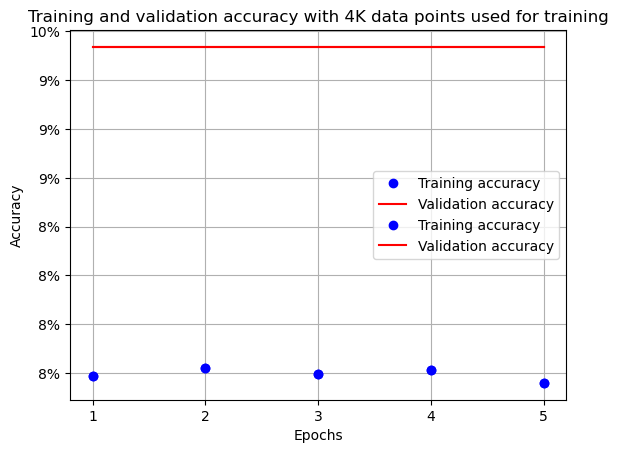

In [27]:
import numpy as np
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

epochs = np.arange(5) + 1

plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.title('Training and validation accuracy with 4K data points used for training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.grid('off')
plt.legend()
plt.show()